# Environment setup
(The project folder needs to be added to your gdrive for everything to work without editing)

In [1]:
!pip install ortools # Google's solver library

     |████████████████████████████████| 27.9MB 1.3MB/s 
     |████████████████████████████████| 1.3MB 40.4MB/s 
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninstalled protobuf-3.10.0


In [2]:
# General libraries (q commonly used in most stuff)
import matplotlib.pyplot as plt # Basic plotting library
import numpy as np              # Work with arrays and matrices efficiently
import pandas as pd             # Work with tables nicely
import seaborn as sns           # Nicer interface to matplotlib.pyplot

# Other libraries
from collections import defaultdict
from google.colab import drive
from ortools.linear_solver import pywraplp
from pathlib import Path

drive.mount('content/')
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at content/


# Load data
In general,
- XXXX_info.csv files contain information related only to XXXX
- XXXX_YYYY.csv files contain information relating XXXX to YYYY

These files are prepared in the data_preprocessing notebook.

In [0]:
root = Path('content/My Drive/IE4210 Group Project')
data = root / 'data'

In [0]:
jobs_info = pd.read_csv(data/'jobs_info.csv').set_index('Job Classification')
jobs_skills = pd.read_csv(data/'jobs_skills.csv').set_index('Job Classification')

prog_info = pd.read_csv(data/'prog_info.csv').set_index('Program')
prog_skills = pd.read_csv(data/'prog_skills.csv').set_index('Program')
prog_clash = pd.read_csv(data/'prog_clash.csv').set_index('Program')

skills_info = pd.read_csv(data/'skills_info.csv').set_index('Number')

In [5]:
jobs_skills.sample()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
Job Classification,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Technician,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1


In [6]:
prog_info.sample()

,Enrollment Cost ($),Duration (days)
Program,,
4,575,3


# Further analysis
Find optimal assignments for multiple employees with program fixed costs and program enrollment limits.

1. Find top k plans for each job type
2. Find near optimal mix of plans that meets additional constraints

## Step 1: K best jobs

In [0]:
# Sets
J = jobs_info.index
P = prog_info.index
S = skills_info.index
Y = np.arange(3) # The number of years

# Parameters
k = jobs_info['Salary ($)'] / 250 # annual salary / workdays per year
c = prog_info['Enrollment Cost ($)']
t = prog_info['Duration (days)']

subproblem = dict()
for j in J:
  model = pywraplp.Solver(f'{j} assignment', pywraplp.Solver.SAT_INTEGER_PROGRAMMING)
  model.SetNumThreads(2)

  # Variables
  x = defaultdict(dict)
  for p in P:
    for y in Y:
      x[p][y] = model.BoolVar(f'assign program {p} in year {y}')
  
  # Objective function
  z1 = sum(c[p]*x[p][y] for j in J for p in P for y in Y)
  z2 = sum(k[j]*t[p]*x[p][y] for j in J for p in P for y in Y)
  model.Minimize(z1 + z2) # Real cost + opp. cost

  # Program constraints
  for p1 in P:
    for p2 in P:
      if (p2 > p1) and prog_clash.loc[p1, str(p2)] == 1:
        for y in Y:
          model.Add(x[p1][y] + x[p2][y] <= 1, f'year {y} {p1} {p2} clash')
  
  # Skill constraints
  for s in S:
    if jobs_skills.loc[j, str(s)] == 1:
      model.Add(sum(x[p][y] for p in P for y in Y if prog_skills.loc[p, str(s)]) >= 1, f'skill {s}')

  # Annual constraints
  for y in Y:
    model.Add(sum(x[p][y] for p in P) <= 5, f'year {y} max programs')
    model.Add(sum(t[p]*x[p][y] for p in P) >= 5, f'year {y} min hours')
    model.Add(sum(t[p]*x[p][y] for p in P) <= 15, f'year {y} max hours')

  subproblem[j] = (model, x, z1, z2)

In [12]:
objective_records = list()
solutions_records = list()
K = range(50) 

for j, (model, x, z1, z2) in subproblem.items():
  print(j, end='')
  for k in K:
    print('.', end='')
    if model.Solve() == model.OPTIMAL:
      objective_records.append({
          'job': j,
          'plan': k,
          'real cost': z1.solution_value(),
          'opp. cost': z2.solution_value(),
          'total': model.Objective().Value(),
      })
      solutions_records.extend([{
          'job': j, 
          'plan': k,
          'program': p, 
          'year': y, 
          'assignment': x[p][y].solution_value()
      } for p in P for y in Y])

      # checksum > 0 if and only if at least one x variable flips its value
      checksum_0 = sum(x[p][y] for p in P for y in Y if int(x[p][y].solution_value())==0)      
      checksum_1 = sum(1-x[p][y] for p in P for y in Y if int(x[p][y].solution_value())==1)
      
      # Add unique cut for previous solution
      model.Add(checksum_0 + checksum_1 >= 1)

      # Set previous solution as starting BFS for potential speedup
      model.SetHint(
          [x[p][y] for p in P for y in Y],
          [x[p][y].solution_value() for p in P for y in Y],
      )
    else:
      break # Less than K feasible solutions
  print()

base_objective = pd.DataFrame.from_records(objective_records)
base_solutions = pd.DataFrame.from_records(solutions_records)
base_solutions['cost'] = c[base_solutions.program].values * base_solutions.assignment
base_solutions['time'] = t[base_solutions.program].values * base_solutions.assignment

Senior Manager..................................................
Project Manager..................................................
Professional..................................................
Sales..................................................
Technician..................................................
Administrative Assistant..................................................


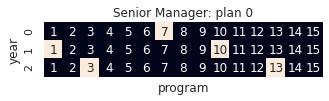

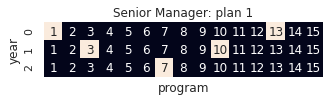

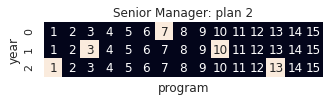

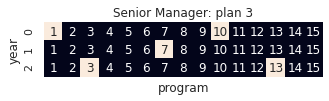

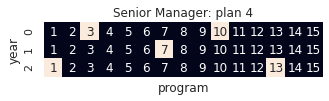

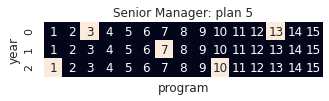

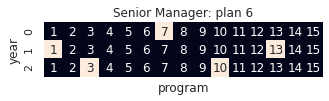

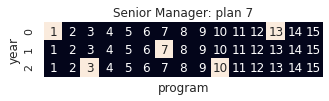

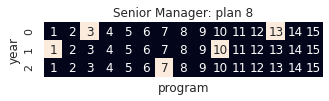

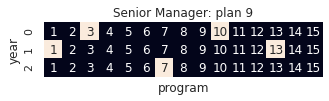

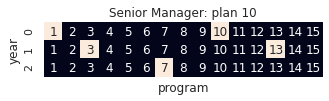

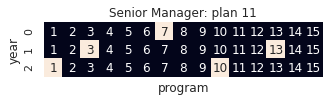

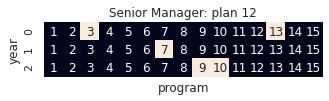

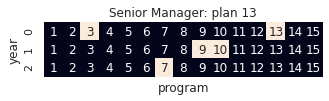

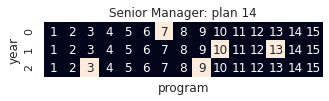

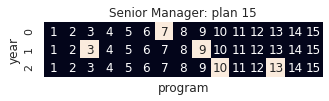

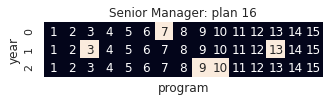

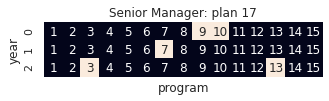

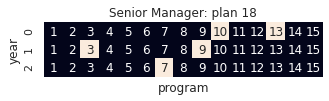

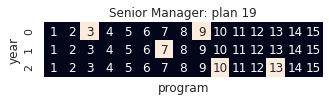

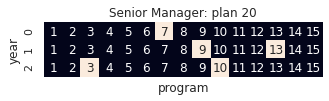

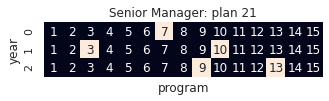

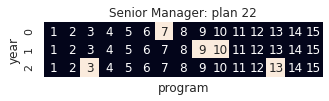

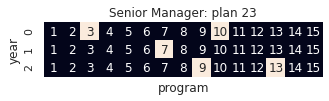

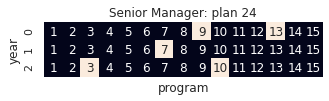

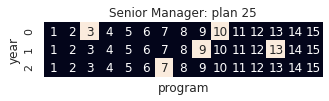

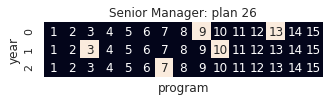

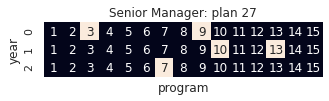

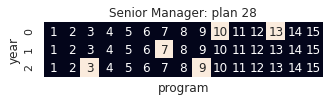

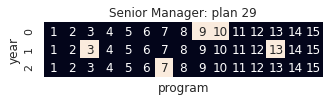

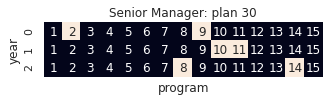

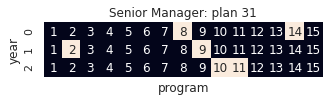

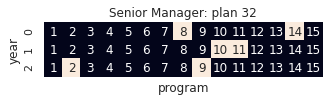

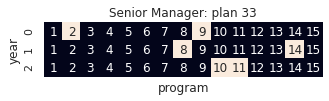

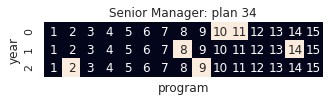

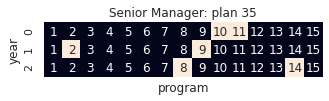

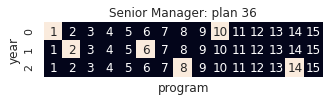

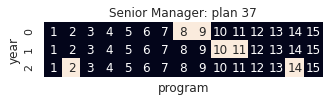

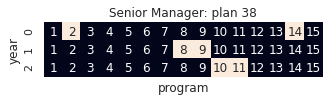

KeyboardInterrupt: ignored

In [9]:
for j in J:
  for k in K:
    # Plot assignments
    plt.figure(figsize=(5, 1))
    sns.heatmap(
        data = base_solutions[(base_solutions.job==j) & (base_solutions.plan==k)].pivot('year', 'program', 'assignment'), 
        annot = len(Y)*[P], 
        cbar=False, 
        xticklabels=False
    ).set_title(f'{j}: plan {k}')
    plt.show()

  # Print Objectives
  print(base_objective[base_objective.job==j])

In [0]:
base_objective.to_csv(root/'results'/'top_k_objective.csv', index=False)
base_solutions.to_csv(root/'results'/'top_k_solutions.csv', index=False)

## Step 2: Near optimal solutions

In [0]:
base_objective = pd.read_csv(root/'results'/'top_k_objective.csv')
base_solutions = pd.read_csv(root/'results'/'top_k_solutions.csv')

In [0]:
base_objective.head()

,job,plan,real cost,opp. cost,total
0,Senior Manager,0,12600.0,63240.0,75840.0
1,Senior Manager,1,12600.0,63240.0,75840.0
2,Senior Manager,2,12600.0,63240.0,75840.0
3,Senior Manager,3,12600.0,63240.0,75840.0
4,Senior Manager,4,12600.0,63240.0,75840.0


In [0]:
base_solutions.head()

,job,plan,program,year,assignment,cost,time
0,Senior Manager,0,1,0,0.0,0.0,0.0
1,Senior Manager,0,1,1,0.0,0.0,0.0
2,Senior Manager,0,1,2,1.0,500.0,2.0
3,Senior Manager,0,2,0,0.0,0.0,0.0
4,Senior Manager,0,2,1,0.0,0.0,0.0


In [0]:
# Sets
J = jobs_info.index
P = prog_info.index
K = range(50)
Y = range(3)

# Parameters
# Number of employees in each job class
n_small = pd.Series((2, 4, 4, 6, 7, 7), index=J)
n_medium = pd.Series((5, 17, 18, 40, 65, 65), index=J)
n_large = pd.Series((20, 100, 100, 180, 300, 300), index=J)
n = n_large #  set scenario

# Costs of each job plan
c1 = base_objective.set_index(['job', 'plan'])['real cost']
c2 = base_objective.set_index(['job', 'plan'])['opp. cost']

# fixed cost of each program
c = prog_info['Enrollment Cost ($)']

# Program useage by plan
u = base_solutions.set_index(['job', 'plan', 'program', 'year'])['assignment']

# Enrollment limit of each program
L = 100

model = pywraplp.Solver('fine assignment', pywraplp.Solver.SAT_INTEGER_PROGRAMMING)

# Variables
x = defaultdict(dict)
for j in J:
  for k in K:
    x[j][k] = model.IntVar(0, model.Infinity(), f'number of {j} assigned to plan {k}')

w = defaultdict(dict)
for p in P:
  for y in Y:
    w[p][y] = model.BoolVar(f'program {p} used in year {y}')

v = defaultdict(dict)
for p in P:
  for y in Y:
    v[p][y] = model.IntVar(0, model.Infinity(), f'in house alternative for {p} used in year {y}')

# Objective function
z1 = sum(c1[j][k]*x[j][k] for j in J for k in K)
z2 = sum(c2[j][k]*x[j][k] for j in J for k in K)
z3 = sum(5*c[p]*w[p][y] for p in P for y in Y)
z4 = sum(3*c[p]*v[p][y] for p in P for y in Y)
model.Minimize(z1 + z2 + z3 + z4) # Real cost + opp. cost + fixed vendor cost + variable in-house cost

# Employee constraints
for j in J:
  model.Add(sum(x[j][k] for k in K) == n[j])

# Enrollment limits
for p in P:
  for y in Y:
    model.Add(sum(x[j][k] for j in J for k in K if u[j, k, p, y]==1) <= L*w[p][y] + v[p][y], f'enrollment limit for program {p} in year {y}')

In [0]:
status = model.Solve()

if status == model.INFEASIBLE:
  print('INFEASIBLE')

elif status == model.UNBOUNDED:
  print('UNBOUNDED')

elif status == model.OPTIMAL:
  print('OPTIMAL')
  fine_records = list()
  for j in J:
    for k in K:
      fine_records.append({
          'job': j,
          'plan': k,
          'assignment': x[j][k].solution_value(),
      })
  fine_solutions = pd.DataFrame.from_records(fine_records)
  fine_objective = pd.Series({
    'real cost': z1.solution_value(),
    'opp. cost': z2.solution_value(),
    'fixed cost': z3.solution_value(),
    'in-house cost': z4.solution_value(),
    'total': model.Objective().Value(),
  })

else:
  print('unknown status:', status) 

OPTIMAL


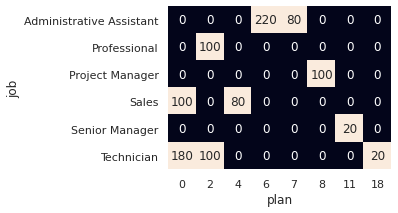

real: 4566.458333333332
opp.: 19021.600000000002


In [0]:
# Plot the plan assignments
table = fine_solutions.pivot('job', 'plan', 'assignment')
reduced_table = table.loc[:, table.sum() != 0]

plt.figure(figsize=[x/2 for x in reduced_table.T.shape])
sns.heatmap(reduced_table>0, annot=reduced_table, fmt='.0f', cbar=False)
plt.show()

# fine_objective
temp = fine_objective / n.sum() / len(Y)
print('real:', temp['total'] - temp['opp. cost'])
print('opp.:', temp['opp. cost'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  import sys


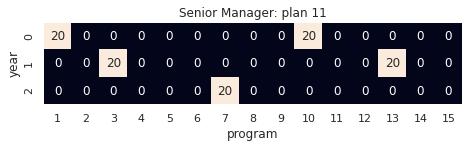

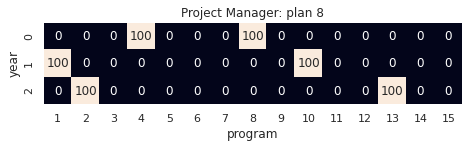

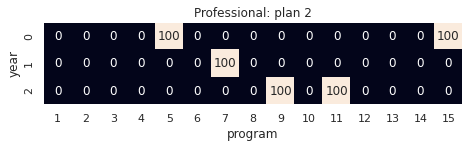

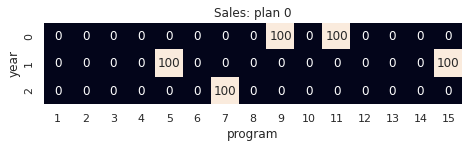

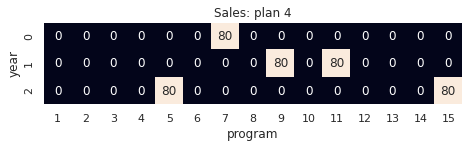

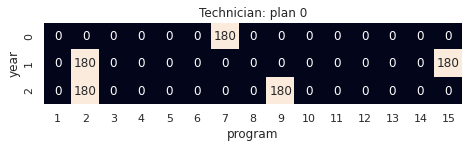

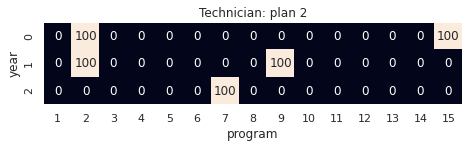

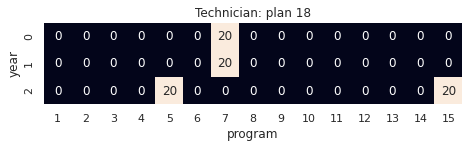

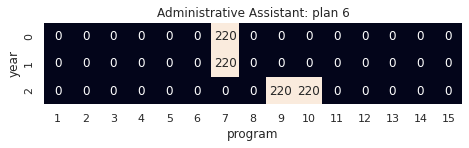

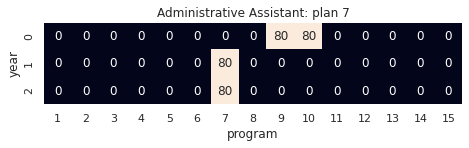

In [0]:
# Plot the program assignment for each plan
plans = base_solutions.set_index(['job', 'plan'])

for j in J:
  for k in K:
    size = table.loc[j, k]
    if size > 0:
      plan = size * plans.loc[j, k].pivot('year', 'program', 'assignment')
      
      plt.figure(figsize=[x/2 for x in plan.T.shape])
      sns.heatmap(plan, annot=plan, fmt='.0f', cbar=False).set_title(f'{j}: plan {k}')
      plt.show()